<center><image src="https://drive.google.com/uc?id=1n3G4TdK_u6PQHcLrxB_A0HijNdigXmUH">

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Сегментация изображений</b></h3>


В этом задании вам предстоит решить задачу сегментации медицинских снимков. Домашнее задание можно разделить на следующие части:

* Построй свой первый бейзлайн! [6]
  * BCE Loss [2]
  * SegNet [2]
  * Train [1]
  * Test [1]
* Мир других лоссов! [2]
  * Dice Loss [1]
  * Focal Loss [1]
  * BONUS: лосс из статьи [5]
* Новая модель! [2]
  * UNet [2]


**Максимальный балл:** 10 баллов.

Также для студентов желающих еще более углубиться в задачу предлагается решить бонусное задание, которое даст дополнительные 5 баллов. BONUS задание необязательное.


# Загрузка данных

1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>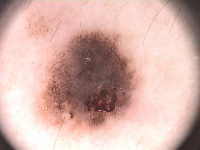</td><td>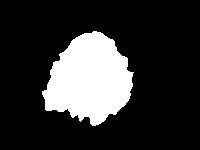</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [1]:
!gdown 1T_RPkPP0jeWwK8L1UrmBw8V30eD7v6Ql

Downloading...
From (original): https://drive.google.com/uc?id=1T_RPkPP0jeWwK8L1UrmBw8V30eD7v6Ql
From (redirected): https://drive.google.com/uc?id=1T_RPkPP0jeWwK8L1UrmBw8V30eD7v6Ql&confirm=t&uuid=ea6c7436-cd9e-4b5d-8f12-5ee2c6e0f62f
To: /content/PH2Dataset.rar
100% 162M/162M [00:04<00:00, 37.5MB/s]


In [2]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [4]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs,files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [5]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [6]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

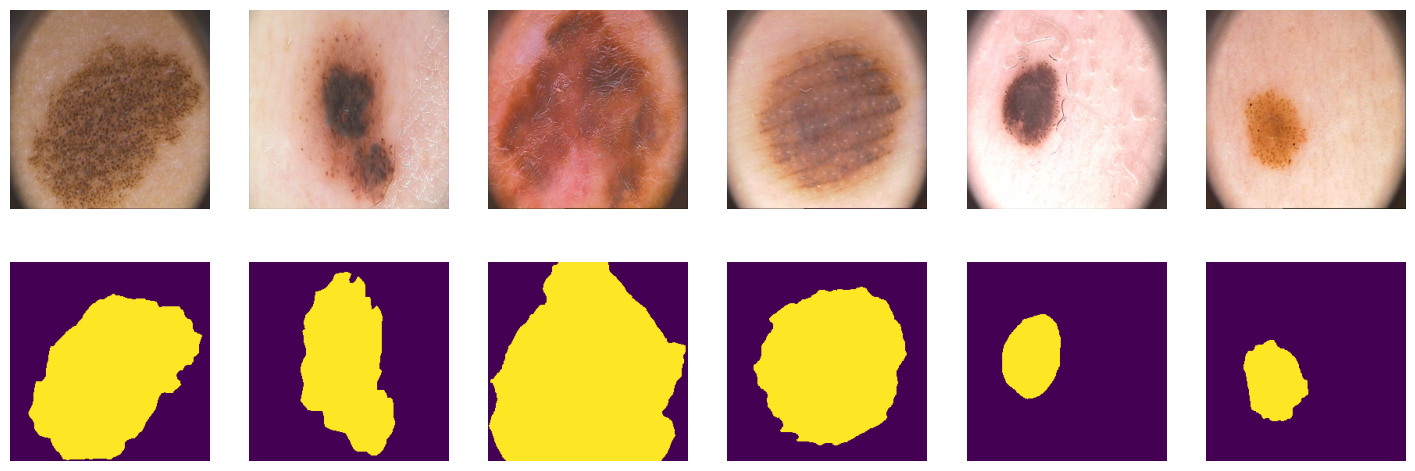

In [7]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [8]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [9]:
print(len(tr), len(val), len(ts))

100 50 50


## PyTorch DataLoader

In [10]:
from torch.utils.data import DataLoader
batch_size = 25
train_dataloader = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [11]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Метрика

## IoU (intersection over union)

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Что будет являться пересением и объединением в задаче сегментации?

Давайте разберем следующий пример:





<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1rBYFgli48AUUN9idiyq8j3J5DboB93yN" width=1000 height=800/></p>

In [11]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 98.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 70.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 72.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [12]:
from torchmetrics import JaccardIndex

iou_score = JaccardIndex(threshold=0.5, task="binary", average='none').to(device)

# Построй свой первый бейзлайн!

Итак, загрузка файлов, код датасета и даталоадера написана за вас. Метрика IoU написана за вас! Вам остается написать лосс, модель и функции обучения и теста модели.

* Построй свой первый бейзлайн! [6]
  * BCE Loss [2]
  * SegNet [2]
  * Train [1]
  * Test [1]

## BCE Loss [2 балла]

Популярным лоссом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right] \space [1]$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right) \space [2]$$

### Вывод численно стабильной формулы BCE лосса [1 балл]



Выведите из формулы [1] формулу [2]:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right] \space [1]$$

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right) \space [2]$$

Не забываем, что здесь $\hat y_i$ - это логиты сети, не вероятности и не лейблы.

**Ответ:**

### Реализуйте в коде оба варианта лосса [1 балл]

Реализуйте следующие функции:

*   `bce_true()` - честная прямая реализация лосса с формулой $$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$
*   `bce_loss()` - реализация формулы, которую мы вывели $$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

И сравните результаты функций с реализацией Pytorch:
*   `bce_torch()`
*   `bce_torch_with_logits()`

In [13]:
import torch.nn.functional as F
import torch.nn as nn

In [14]:
bce_torch = nn.BCELoss(reduction='sum') # (sigmoid(y_pred), y_real)
bce_torch_with_logits = nn.BCEWithLogitsLoss(reduction='sum')

In [15]:
def bce_loss(y_pred, y_real):
  return torch.sum(y_pred - y_real * y_pred + torch.log(1 + torch.exp(-y_pred)))

def bce_true(y_pred, y_real):
  return - torch.sum(y_real * torch.log(torch.sigmoid(y_pred))+(1-y_real)*torch.log(1-torch.sigmoid(y_pred)))

Проверим корректность работы на простом примере

In [16]:
y_pred = torch.randn(3, 2, requires_grad=False)
y_true = torch.rand(3, 2, requires_grad=False)

print(f'BCE loss from scratch bce_loss = {bce_loss(y_pred, y_true)}')
print(f'BCE loss честно посчитанный = {bce_true(y_pred, y_true)}')
print(f'BCE loss from torch bce_torch = {bce_torch(torch.sigmoid(y_pred), y_true)}')
print(f'BCE loss from torch with logits bce_torch = {bce_torch_with_logits(y_pred, y_true)}')


BCE loss from scratch bce_loss = 5.273793697357178
BCE loss честно посчитанный = 5.273793697357178
BCE loss from torch bce_torch = 5.273793697357178
BCE loss from torch with logits bce_torch = 5.273793697357178


Инструкции `assert` в Python — это булевы выражения, которые проверяют, является ли условие истинным (`True`). Внизу в коде мы проверяем функция `bce_loss()` выдает тот же результат, что и функция из Pytorch или нет. Если равенства не будет, что будет означать, что результаты функций не совпадают, а значит вы неправильно реализовали фукнцию `bce_loss()`, `assert` возвратит ошибку.

Функция `numpy.isclose()` используется для сравнения двух чисел с учётом допустимой погрешности. Она особенно полезна при работе с числами с плавающей точкой, где точное сравнение может быть проблематичным из-за ограничений представления таких чисел в компьютере.

Как она работает?

`numpy.isclose(a, b, rtol=1e-05, atol=1e-08) `принимает два числа (`a` и `b`) и сравнивает их, учитывая относительную и абсолютную погрешность. Если разница между двумя числами меньше заданного порога, функция возвращает `True`, иначе — `False`.

Параметры:

    rtol: Относительная погрешность (по умолчанию 1e-05). Используется для определения разницы относительно большего значения.
    atol: Абсолютная погрешность (по умолчанию 1e-08). Определяет минимальную разницу, которую следует учитывать.

Мы будем использовать `assert` и `numpy.isclose()` для проверки корректности нашего кода.

In [17]:
assert np.isclose(bce_loss(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true))
assert np.isclose(bce_loss(y_pred, y_true), bce_torch_with_logits(y_pred, y_true))
assert np.isclose(bce_true(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true))
assert np.isclose(bce_true(y_pred, y_true), bce_torch_with_logits(y_pred, y_true))

Давайте теперь посчитаем на простом примере, но с теми же размерностями, что и в датасете

In [18]:
y_pred = torch.randn((2, 1, 3, 3), requires_grad=False)
y_true = torch.randint(0, 2, (2, 1, 3, 3))

print(f'BCE loss from scratch bce_loss = {bce_loss(y_pred, y_true)}')
print(f'BCE loss честно посчитанный = {bce_true(y_pred, y_true)}')
print(f'BCE loss from torch bce_torch = {bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float))}')
print(f'BCE loss from torch with logits bce_torch = {bce_torch_with_logits(y_pred, y_true.to(torch.float))}')

BCE loss from scratch bce_loss = 14.543111801147461
BCE loss честно посчитанный = 14.543110847473145
BCE loss from torch bce_torch = 14.543111801147461
BCE loss from torch with logits bce_torch = 14.543111801147461


In [19]:
assert np.isclose(bce_loss(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float)))
assert np.isclose(bce_loss(y_pred, y_true), bce_torch_with_logits(y_pred, y_true.to(torch.float)))
assert np.isclose(bce_true(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float)))
assert np.isclose(bce_true(y_pred, y_true), bce_torch_with_logits(y_pred, y_true.to(torch.float)))

Давайте посчитаем на реальных логитах и сегментационной маске:

In [20]:
!gdown --folder 1EX0RW1TRQVkLmR1h6miCQqyhYPFyg28M

Retrieving folder contents
Processing file 1--WxvBdpMn_NOmYPf3a4au8MHzfx5baC labels.pt
Processing file 1-0A7_CS_vKiSCkgIDJ4joThCEcFedA3I logits.pt
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1--WxvBdpMn_NOmYPf3a4au8MHzfx5baC
To: /content/for_asserts/labels.pt
100% 1.18k/1.18k [00:00<00:00, 5.01MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-0A7_CS_vKiSCkgIDJ4joThCEcFedA3I
To: /content/for_asserts/logits.pt
100% 1.18k/1.18k [00:00<00:00, 5.79MB/s]
Download completed


In [21]:
path_to_dummy_samples = '/content/for_asserts'
dummpy_sample = {'logits': torch.load(f'{path_to_dummy_samples}/logits.pt'),
                 'labels': torch.load(f'{path_to_dummy_samples}/labels.pt')}
dummpy_sample['labels'] = dummpy_sample['labels'].to(device)
dummpy_sample['logits'] = dummpy_sample['logits'].to(device)

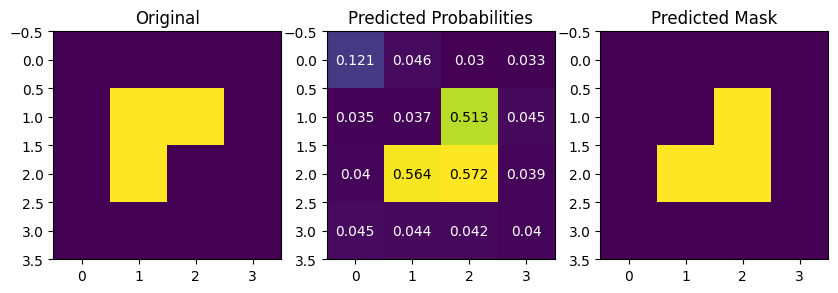

In [22]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize= (10,3*10))

ax1.imshow(dummpy_sample['labels'].squeeze(1)[0].cpu())
ax1.set_title("Original")

ax2.imshow(dummpy_sample['logits'].sigmoid().squeeze(1)[0].cpu())
for (j,i),label in np.ndenumerate(dummpy_sample['logits'].sigmoid().squeeze(1)[0].cpu()):
    if label < 0.5:
        color = 'white'
    else:
        color = 'black'
    ax2.text(i,j,round(label,3), color=color, ha='center',va='center')

ax2.set_title("Predicted Probabilities")

ax3.imshow((dummpy_sample['logits'].sigmoid() > 0.5).squeeze(1)[0].cpu())
ax3.set_title("Predicted Mask")
plt.show()

Проверяем на данном примере:

In [23]:
bce_loss_score = bce_loss(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu())
bce_true_score = bce_true(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu())
bce_torch_score = bce_torch(torch.sigmoid(dummpy_sample['logits'].cpu()), dummpy_sample['labels'].cpu().float())
bce_torch_with_logits_score = bce_torch_with_logits(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu().float())
assert np.isclose(bce_loss_score, bce_torch_score)
assert np.isclose(bce_loss_score, bce_torch_with_logits_score)
assert np.isclose(bce_true_score, bce_torch_score)
assert np.isclose(bce_true_score, bce_torch_with_logits_score)

## SegNet [2 балла]

Ваше задание здесь состоит в том, чтобы реализовать SegNet архитектуру.

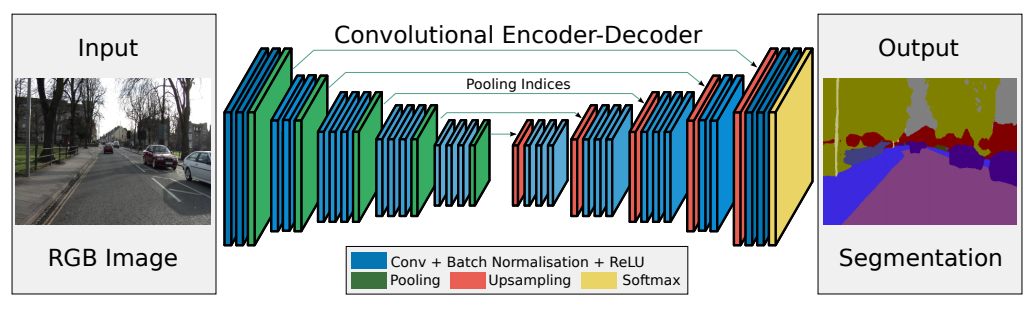

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [14]:
class ConvRelu(nn.Module):
    def __init__(self, in_features, out_channels,kernel_size=3, padding=1):
        super().__init__()
        self.conv = nn.Conv2d(in_channels=in_features,out_channels=out_channels, kernel_size=kernel_size, padding=padding)
        self.norm = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self,x):

        x = self.conv(x)

        x = self.norm(x)
        x = self.relu(x)
        return x

In [15]:
class EncoderBlock(nn.Module):
    def __init__(self, in_features, out_channels, depth = 2, kernel_size=3, padding=1):
        super(EncoderBlock, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(depth):
            self.layers.append(ConvRelu(in_features=(in_features if i==0 else out_channels),out_channels=out_channels,kernel_size=kernel_size,padding=padding))
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x,idx = self.pool(x)

        return x, idx

In [16]:
class DecoderBlock(nn.Module):
    def __init__(self, in_features, out_channels, depth=2,kernel=3, padding=1, is_classification = False):
        super(DecoderBlock, self).__init__()
        self.layers = nn.ModuleList()
        self.unpool = nn.MaxUnpool2d(kernel_size=2,stride=2)
        for i in range(depth):
            if is_classification and i==depth-1:
                self.layers.append(nn.Conv2d(in_channels=in_features,out_channels=out_channels,kernel_size=kernel,padding = padding))
            elif i == depth-1:
                self.layers.append(ConvRelu(in_features=in_features, out_channels=out_channels,kernel_size=kernel,padding=padding))
            else:
                self.layers.append(ConvRelu(in_features=in_features,out_channels=in_features,kernel_size=kernel,padding=padding))


    def forward(self,x,idx):
        x = self.unpool(x,idx)
        for layer in self.layers:
            x = layer(x)
        return x

Хорошие ресурсы по SegNet архитектуре:
1. https://medium.com/@nikdenof/segnet-from-scratch-using-pytorch-3fe9b4527239


In [17]:
class SegNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super().__init__()
        features = 64

        # VGG-16 architecture
        self.enc0 = EncoderBlock(in_features=in_channels,out_channels=features)
        self.enc1 = EncoderBlock(features,features*2)
        self.enc2 = EncoderBlock(features*2,features*4, depth=3)
        self.enc3 = EncoderBlock(features*4,features*8, depth=3)

        # bottleneck
        self.b0 = EncoderBlock(features*8,features*8,depth=3)
        self.b1 = DecoderBlock(features*8,features*8,depth=3)

        # decoder (upsampling)
        self.dec0 = DecoderBlock(features*8,features*4,depth=3)
        self.dec1 = DecoderBlock(features*4,features*2,depth=3)
        self.dec2 = DecoderBlock(features*2,features)
        self.dec3 = DecoderBlock(features,out_channels=out_channels, is_classification=True)

    def forward(self, x):
        # encoder
        x, idx0 = self.enc0(x)
        x, idx1 = self.enc1(x)
        x, idx2 = self.enc2(x)
        x, idx3 = self.enc3(x)

        # bottleneck
        x, idx_b = self.b0(x)
        x = self.b1(x, idx_b)

        # decoder
        x = self.dec0(x, idx3)
        x = self.dec1(x, idx2)
        x = self.dec2(x, idx1)
        output = self.dec3(x, idx0)

        return output # no activation

In [37]:
segnet_model = SegNet().to(device)

## Тренировка [1 балл]

Напишите функцию для обучения модели.

In [19]:
from tqdm.notebook import tqdm

In [20]:
def train_epoch(model, criterion, optimizer, epoch, train_loader, lr_scheduler = None):
        model.train()
        avg_epoch_loss = 0

        for X,y in tqdm(train_loader):
            X = X.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            outputs = model(X)

            if criterion._get_name()=='BCELoss':
                loss = criterion(F.sigmoid(outputs), y)
            else:
                loss = criterion(outputs, y)

            loss.backward()
            optimizer.step()

            avg_epoch_loss += loss.item()

        if lr_scheduler:
            lr_scheduler.step()

        avg_epoch_loss = avg_epoch_loss / len(train_dataloader)

        print(f'Epoch {epoch+1}: avg train loss with {criterion._get_name()}: {avg_epoch_loss}')


        return loss.item()


In [35]:
def val_epoch(model, criterion, epoch, valid_dataloader):
    iou_score = JaccardIndex(threshold=0.5, task="binary", average='none').to(device)
    model.eval()
    avg_loss = 0
    avg_iou = 0
    with torch.no_grad():
        for X, y_real in tqdm(valid_dataloader):
            X = X.to(device)
            y_real = y_real.to(device)

            y_pred = model(X).cuda()
            iou = iou_score(y_pred, y_real)
            if criterion._get_name()=='BCELoss':
                loss = criterion(F.sigmoid(y_pred), y_real)
            else:
                loss = criterion(y_pred, y_real)

            avg_loss += loss.item()
            avg_iou += iou

    avg_loss = avg_loss/len(valid_dataloader)
    avg_iou = avg_iou/len(valid_dataloader)
    print(f'Epoch {epoch+1}: avg val loss with {criterion._get_name()}: {avg_loss}, avg iou: {avg_iou}')
    return avg_loss, avg_iou

In [22]:
def train(model, criterion, optimizer, epochs, train_loader, val_loader, lr_scheduler = None):

    train_epochs_loss = []
    val_epochs_loss = []
    ious = []

    best_val_loss = float('inf')
    best_val_iou = 0

    for epoch in tqdm(range(epochs)):
        train_epoch_loss = train_epoch(model, criterion, optimizer,epoch,train_dataloader,lr_scheduler)
        val_epoch_loss, iou = val_epoch(model, criterion, epoch, valid_dataloader)

        train_epochs_loss.append(train_epoch_loss)
        val_epochs_loss.append(val_epoch_loss)
        ious.append(iou)

        if val_epoch_loss < best_val_loss:
            best_val_loss = val_epoch_loss
            torch.save(model.state_dict(), f'/content/checkpoints/{model._get_name()}_{criterion._get_name()}/epoch_{epoch}_best_val_loss.pt')

        torch.save(model.state_dict(), f'/content/checkpoints/{model._get_name()}_{criterion._get_name()}/epoch_{epoch}_val_iou.pt')

    statistics = {'train loss': train_epochs_loss,
                  'val_loss': val_epochs_loss,
                  'val_iou': ious}

    return model, statistics

Обучите модель **SegNet**. В качестве оптимайзера можно взять Adam.

In [38]:
total_epochs = 20
criterion = nn.BCELoss(reduction='sum')
optimizer = optim.Adam(segnet_model.parameters())
lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

loss1 = train(segnet_model,criterion,optimizer,total_epochs,train_dataloader,valid_dataloader,lr_scheduler)


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1: avg train loss with BCELoss: 1098273.515625


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1: avg val loss with BCELoss: 1114887.5, avg iou: 0.0


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2: avg train loss with BCELoss: 851870.90625


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 2: avg val loss with BCELoss: 3371317.5, avg iou: 0.0


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3: avg train loss with BCELoss: 643326.28125


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 3: avg val loss with BCELoss: 5375802.5, avg iou: 0.0


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 4: avg train loss with BCELoss: 586694.3671875


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 4: avg val loss with BCELoss: 3861419.5, avg iou: 0.08478056639432907


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5: avg train loss with BCELoss: 558289.109375


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 5: avg val loss with BCELoss: 1131949.9375, avg iou: 0.05815902724862099


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 6: avg train loss with BCELoss: 479849.8359375


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 6: avg val loss with BCELoss: 808801.625, avg iou: 0.33424973487854004


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 7: avg train loss with BCELoss: 450332.703125


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 7: avg val loss with BCELoss: 562358.609375, avg iou: 0.6314525604248047


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 8: avg train loss with BCELoss: 400702.6171875


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 8: avg val loss with BCELoss: 517932.0, avg iou: 0.6627447605133057


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 9: avg train loss with BCELoss: 367373.6640625


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 9: avg val loss with BCELoss: 531414.1875, avg iou: 0.6448136568069458


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10: avg train loss with BCELoss: 361882.265625


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 10: avg val loss with BCELoss: 457825.5, avg iou: 0.7069582343101501


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 11: avg train loss with BCELoss: 388196.6015625


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 11: avg val loss with BCELoss: 443072.359375, avg iou: 0.7101118564605713


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 12: avg train loss with BCELoss: 350050.4140625


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 12: avg val loss with BCELoss: 457647.09375, avg iou: 0.6688677072525024


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 13: avg train loss with BCELoss: 319072.21875


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 13: avg val loss with BCELoss: 385072.3125, avg iou: 0.7529486417770386


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 14: avg train loss with BCELoss: 376146.6953125


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 14: avg val loss with BCELoss: 467541.8125, avg iou: 0.6717043519020081


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 15: avg train loss with BCELoss: 309892.7578125


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 15: avg val loss with BCELoss: 378950.3828125, avg iou: 0.761529803276062


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 16: avg train loss with BCELoss: 296496.11328125


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 16: avg val loss with BCELoss: 407170.0, avg iou: 0.7385417222976685


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 17: avg train loss with BCELoss: 315850.6171875


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 17: avg val loss with BCELoss: 366824.390625, avg iou: 0.764845073223114


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 18: avg train loss with BCELoss: 319490.23046875


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 18: avg val loss with BCELoss: 432219.859375, avg iou: 0.7366474270820618


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 19: avg train loss with BCELoss: 289193.4296875


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 19: avg val loss with BCELoss: 391252.859375, avg iou: 0.7358344197273254


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 20: avg train loss with BCELoss: 271599.7421875


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 20: avg val loss with BCELoss: 348295.828125, avg iou: 0.7706486582756042


## Инференс [1 балл]

После обучения модели напишите фукнцию теста, воспользуйтесь лучшим чекпоинтом и протестируйте работу модели на тестовой выборке.

In [54]:
def test(test_loader, model, ckpt_path,ckpt_name):
    model.load_state_dict(torch.load(f'{ckpt_path}/{ckpt_name}'))
    model.to(device)
    model.eval()

    iou_score = JaccardIndex(threshold=0.5, task="binary", average='none').to(device)
    avg_iou = 0
    with torch.no_grad():
      for X_batch, Y_batch in test_dataloader:
          X_batch = X_batch.to(device)
          Y_batch = Y_batch.to(device)

          Y_pred = model(X_batch)
          avg_iou += iou_score(Y_pred, Y_batch) # , threshold = 0.5)
      avg_iou = avg_iou / len(test_dataloader)

    return avg_iou


In [55]:
test(test_dataloader,segnet_model,ckpt_path='/content/checkpoints/',ckpt_name='epoch_19_best_val_loss.pt')

tensor(0.7353, device='cuda:0')

# Мир других лоссов!

## Дополнительные функции потерь [2 балла]

В данном разделе вам потребуется имплементировать две функции потерь: DICE и Focal loss.


### Dice Loss

**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

В терминах матрицы ошибок она будет считаться следующим образом:

$$D(X,Y) = \frac{2TP}{2TP + FP + FN}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1- D(X, Y)$$

**Hints** (!):

1. Не забудьте подумать о численной нестабильности, возникающей в математической формуле при ситуации, когда $\frac{0}{0}$, т.е. вам нужно добавить очень маленькое число, например $\epsilon = 1e^{-8}$, в обе части дроби при подсчете $D(X,Y)$:

$$D(X,Y) = \frac{2TP + ϵ}{2TP + FP + FN + ϵ}$$

2. Dice метрика(!), не лосс, считается похожим образом как IoU:

    2.1. На вход вам приходят logits, т.е. значения от $-∞$ до $∞$. Их переводим в вероятности от 0 до 1 при помощи функции Sigmoid.

    2.2. Фиксируем порог, например threshold=0.5, и всему что ниже порога ставим значение 0, всему что выше 1. Получаем предсказанную маску из 0 и 1.

    2.3. Считаем TP, FP, FN

    2.4. Считаем DICE метрику по формуле

Вы можете прописать для себя функцию `dice_score()` и сравнить с результатами работы функции из библиотеки `torchmetrics`.

3. Но с метрикой есть проблема, что она не дифференцируема, и если вы захотите просто взять и прописать `dice_loss` = 1 - `dice_score`, Pytorch поругается на вас и скажет, что это недифференцируемая метрика. Чтобы посчитать dice_loss делаем следующие шаги:

    3.1. На вход вам приходят logits, т.е. значения от $-∞$ до $∞$. Их переводим в вероятности от 0 до 1 при помощи функции Sigmoid.

    3.2. Здесь нам уже не нужно фиксировать порог, мы просто работаем с вероятностями. Значения вероятностей дифференцируемы и через них будут протекать градиенты.

    3.3. Считаем TP, FP, FN также как и в Dice метрике, только вместо маски, подаем вероятности.

    3.4. Считаем DICE метрику по формуле

    3.5. Считаем лосс как Loss = 1 - DICE

Итак, давайте сначала пропишем dice_score.

In [ ]:
def dice_score(logits: torch.Tensor, labels: torch.Tensor, threshold: float = 0.5):
    '''
    Это именно метрика, не лосс.
    '''
    prob_mask = logits.sigmoid()
    pred_mask = (prob_mask > threshold).float()
    tp = torch.sum(pred_mask*labels)
    fp = torch.sum(pred_mask) - tp
    fn = torch.sum(labels) - tp

    print(tp,fp,fn)
    print(binary_stat_scores(pred_mask, labels, threshold=0.5))
    eps = 1e-8 # to avoid 0/0


    score = (2*tp+eps)/(2*tp+fp+fn+eps)
    return score

Проверим на корректность функцию dice_score:

In [ ]:
from torchmetrics.segmentation  import DiceScore

dice = DiceScore(num_classes=2,average='micro').to(device)
dice(dummpy_sample['logits'].sigmoid()>0.5, dummpy_sample['labels'].to(int))

tensor(0.6667, device='cuda:0')

In [ ]:
assert dice(dummpy_sample['logits'].sigmoid()>0.5, dummpy_sample['labels'].to(int)) == dice_score(dummpy_sample['logits'], dummpy_sample['labels'])

Давайте теперь пропишем лосс и воспользуемся библиотекой `segmentation-models-pytorch`, чтобы убедиться в корректности нашей функции.

In [ ]:
def dice_loss(logits: torch.Tensor, labels: torch.Tensor):

    '''
    Это лосс.
    '''
    prob_mask =logits.sigmoid()
    tp = torch.sum(prob_mask*labels)
    fp = torch.sum(prob_mask) - tp
    fn = torch.sum(prob_mask) - tp
    eps = 1e-8 # to avoid 0/0

    score = (2*tp+eps)/(2*tp+fp+fn+eps)
    loss = 1-score
    return loss

Проверка на корректность:

In [ ]:
!pip install segmentation_models_pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 10.6 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16426 sha256=544ca94570e7145834e6fdeb358693daf4c86c0fad3f91edc448b846b5ac7f20
  Stored in directory: /root/.cache/pip/wheels/8b/6f/9b/231a832f811ab6ebb1b32455b177ffc6b8b1cd8de19de70c09
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=f1e24817325d7a0a6d954180a978dc2c7ac043678df1b142a050b1da2fb188fb
  Stored in directory: /root/.cache/pip/wheels/5f/5b/96/fd94bc35962d7c6b699e8814db545155ac91d2b95785e1b035
Successfully built efficientnet-pytorch pretrainedmodels


In [ ]:
from segmentation_models_pytorch.losses import DiceLoss
dice_loss_torch = DiceLoss(mode='binary')
dice_loss_torch(dummpy_sample['logits'], dummpy_sample['labels'])

tensor(0.5756, device='cuda:0')

In [ ]:
dice_loss(dummpy_sample['logits'], dummpy_sample['labels'])

tensor(1.1134, device='cuda:0') tensor(1.1335, device='cuda:0') tensor(1.1335, device='cuda:0')
tensor([ 2,  1, 12,  1,  3], device='cuda:0')


tensor(0.3333, device='cuda:0')

In [ ]:
assert dice_loss_torch(dummpy_sample['logits'], dummpy_sample['labels'].to(int)) == dice_loss(dummpy_sample['logits'], dummpy_sample['labels'])

AssertionError: 

### Focal Loss

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf)

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.


Из оригинальной статьи по [Focal Loss](https://arxiv.org/pdf/1708.02002.pdf):

$$p_t = \sigma(\hat y_i)y_i + (1 - \sigma(\hat y_i)) (1-y_i)$$

$$\mathcal L_{focal}(y, \hat y) = (1 - p_t)^{\gamma} \mathcal L_{BCE}(y_i, \hat y_i).$$

$$\mathcal L_{focal}(y, \hat y) = -\sum_i (1 - p_t)^{\gamma} \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

$$\mathcal L_{focal}(y, \hat y) = -\sum_i (1 - (\sigma(\hat y_i)y_i + (1 - \sigma(\hat y_i)) (1-y_i)))^{\gamma} \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

In [ ]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    loss = - torch.sum(torch.pow(1-(y_pred.sigmoid()*y_real+(1-y_pred.sigmoid())*(1-y_real)),gamma)*(y_real*torch.log(y_pred.sigmoid())+(1-y_real)*torch.log(1-y_pred.sigmoid())))

    return loss

Проверка корректности функции:

In [ ]:
from torchvision.ops import sigmoid_focal_loss
sigmoid_focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], alpha=-1, gamma=2, reduction='sum')

tensor(3.6161, device='cuda:0')

In [ ]:
print(focal_loss(dummpy_sample['labels'], dummpy_sample['logits'], gamma=2.0), sigmoid_focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], alpha=-1, gamma=2, reduction='sum'))
assert sigmoid_focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], alpha=-1, gamma=2, reduction='sum') == focal_loss(dummpy_sample['labels'], dummpy_sample['logits'], gamma=2.0)

tensor(3.6161, device='cuda:0') tensor(3.6161, device='cuda:0')


AssertionError: 

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее, и провести численное сравнение с предыдущими функциями.

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

## Обучите SegNet на новых лоссах

**Задание**: обучите SegNet на новых лоссах и сравните все три лосса:
*   При каком лоссе модель сходится быстрее?
*   При каком лоссе модель выдает наилучшую метрику?

Напишите развернутый ответ на вопросы.



# Новая модель!

## U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

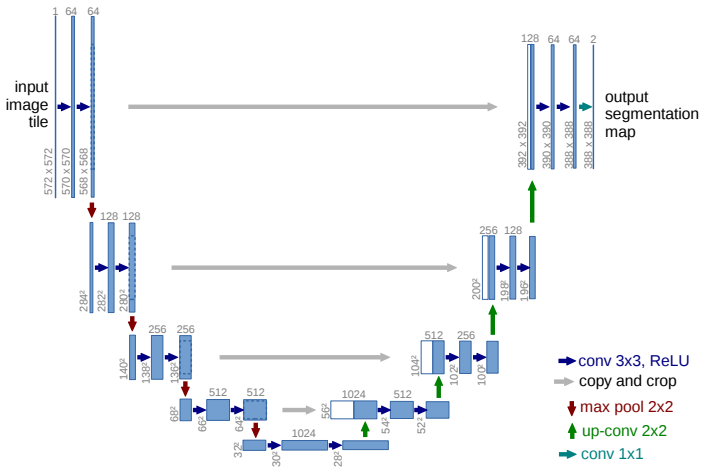

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [44]:
import torch.nn.functional as F
import torch.nn as nn

In [45]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

In [46]:
class UNet(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNet, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

In [47]:
unet_model = UNet().to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(unet_model.parameters())

In [48]:
train(model=unet_model,optimizer=optimizer,criterion=loss_fn,epochs=20,train_loader=train_dataloader,val_loader=valid_dataloader)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1: avg train loss with BCEWithLogitsLoss: 0.6119732186198235


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1: avg val loss with BCEWithLogitsLoss: 0.6814886331558228, avg iou: 0.12631359696388245


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2: avg train loss with BCEWithLogitsLoss: 0.40652405470609665


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 2: avg val loss with BCEWithLogitsLoss: 1.558026373386383, avg iou: 0.3865451216697693


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3: avg train loss with BCEWithLogitsLoss: 0.34984908252954483


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 3: avg val loss with BCEWithLogitsLoss: 4.977833986282349, avg iou: 0.3819318115711212


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 4: avg train loss with BCEWithLogitsLoss: 0.31502099335193634


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 4: avg val loss with BCEWithLogitsLoss: 0.5193101167678833, avg iou: 0.04051334410905838


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5: avg train loss with BCEWithLogitsLoss: 0.3028986304998398


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 5: avg val loss with BCEWithLogitsLoss: 0.7749926745891571, avg iou: 0.0862390473484993


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 6: avg train loss with BCEWithLogitsLoss: 0.287087544798851


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 6: avg val loss with BCEWithLogitsLoss: 0.7185663282871246, avg iou: 0.20697762072086334


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 7: avg train loss with BCEWithLogitsLoss: 0.2648022957146168


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 7: avg val loss with BCEWithLogitsLoss: 0.5727338492870331, avg iou: 0.3656626343727112


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 8: avg train loss with BCEWithLogitsLoss: 0.2648116871714592


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 8: avg val loss with BCEWithLogitsLoss: 0.5052607953548431, avg iou: 0.5322096347808838


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 9: avg train loss with BCEWithLogitsLoss: 0.23995060473680496


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 9: avg val loss with BCEWithLogitsLoss: 0.36761778593063354, avg iou: 0.7032746076583862


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10: avg train loss with BCEWithLogitsLoss: 0.22543393447995186


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 10: avg val loss with BCEWithLogitsLoss: 0.4469995051622391, avg iou: 0.6091457009315491


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 11: avg train loss with BCEWithLogitsLoss: 0.222201406955719


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 11: avg val loss with BCEWithLogitsLoss: 0.3235292434692383, avg iou: 0.7220381498336792


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 12: avg train loss with BCEWithLogitsLoss: 0.22290463745594025


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 12: avg val loss with BCEWithLogitsLoss: 0.3337913900613785, avg iou: 0.6510195732116699


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 13: avg train loss with BCEWithLogitsLoss: 0.22903254628181458


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 13: avg val loss with BCEWithLogitsLoss: 0.28771544992923737, avg iou: 0.7250414490699768


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 14: avg train loss with BCEWithLogitsLoss: 0.22337635606527328


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 14: avg val loss with BCEWithLogitsLoss: 0.2452123537659645, avg iou: 0.7446073293685913


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 15: avg train loss with BCEWithLogitsLoss: 0.18791769817471504


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 15: avg val loss with BCEWithLogitsLoss: 0.27447409927845, avg iou: 0.7268604040145874


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 16: avg train loss with BCEWithLogitsLoss: 0.18515406176447868


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 16: avg val loss with BCEWithLogitsLoss: 0.2395632639527321, avg iou: 0.7555992603302002


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 17: avg train loss with BCEWithLogitsLoss: 0.17369862273335457


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 17: avg val loss with BCEWithLogitsLoss: 0.21371542662382126, avg iou: 0.7904263734817505


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 18: avg train loss with BCEWithLogitsLoss: 0.16299095749855042


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 18: avg val loss with BCEWithLogitsLoss: 0.2191128507256508, avg iou: 0.7973687648773193


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 19: avg train loss with BCEWithLogitsLoss: 0.16131267696619034


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 19: avg val loss with BCEWithLogitsLoss: 0.1993880644440651, avg iou: 0.8054913282394409


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 20: avg train loss with BCEWithLogitsLoss: 0.15913758799433708


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 20: avg val loss with BCEWithLogitsLoss: 0.22192095965147018, avg iou: 0.7954657077789307


(UNet(
   (ups): ModuleList(
     (0): ConvTranspose2d(1024, 512, kernel_size=(2, 2), stride=(2, 2))
     (1): DoubleConv(
       (conv): Sequential(
         (0): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
         (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (2): ReLU(inplace=True)
         (3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
         (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (5): ReLU(inplace=True)
       )
     )
     (2): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
     (3): DoubleConv(
       (conv): Sequential(
         (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
         (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (2): ReLU(inplace=True)
         (3): Conv2d(256, 256, kernel_size=(3, 

## Обучите UNet

Задание: обучите UNet на всех трех лоссах: BCE, Dice, Focal и сравните результаты с SegNet:
*   Какая модель дает лучшие значения по метрике?
*   Какая модель дает лучшие значения по лоссам?
*   Какая модель обучается быстрее?
*   Сравните визуально результаты SegNet и UNet.

Напишите развернутый ответ на вопросы.

